# **Eigenvalue Problem for the Steady Stokes Flow**

The Stokes eigenvalue problem (**SEP**) is:

For a given domain $\Omega \subset \Re$ with Lipschitz boundary, in this case $\Omega = [0,1]\times[0,1]$, find $\lambda \in \Re$, the velocity $\vec{u}$ and the pressure $p$ such that

$$\begin{align*} - \nu \nabla^2\vec{u} + \nabla p &= \lambda \vec{u} \quad \text{in} \quad \Omega, 
\\\nabla \cdot \vec{u} &= 0 \quad \text{in} \quad \Omega, 
\\ \vec{u} &= 0 \quad \text{on} \quad \partial \Omega \end{align*}$$

## _Libraries_

In [1]:
from mpi4py import MPI 
import dolfinx 
import numpy as np 
import ufl
from basix.ufl import element, mixed_element 
from dolfinx import default_real_type, fem, la 
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces, 
    form,
    functionspace,
    locate_dofs_topological,
    create_interpolation_data,
    assemble_scalar
) 
from dolfinx.fem.petsc import assemble_matrix, apply_lifting 
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary 
from ufl import div, dx, grad, inner, TrialFunctions, TestFunctions

from petsc4py import PETSc 
from slepc4py import SLEPc 

## _Escential Functions_

In [2]:
def noslip_boundary(x):
    return np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0) | np.isclose(x[1], 0.0) | np.isclose(x[1], 1.0)

In [3]:
#def pressure_nullmap(A, M, p_index):
#    # A
#    col_indices = A.getRow(p_index)[0] # obtain the indices of (possible) nonzero values in the row
#
#    for i in range(len(col_indices)):
#        A.setValue(p_index, col_indices[i], 0) 
#        A.setValue(col_indices[i], p_index, 0) 
#
#    A.setValue(p_index,p_index, 1)
#    A.assemble()
#
#    # M
#    col_indices = M.getRow(p_index)[0] 
#
#    for i in range(len(col_indices)):
#        M.setValue(p_index, col_indices[i], 0) 
#        M.setValue(col_indices[i], p_index, 0) 
#
#    M.setValue(p_index,p_index, 1)
#    M.assemble()
#    return A, M

In [4]:
def solve_slepc(A, M, mesh, target, nev, tol, eps_shift = 1e-9):
    A.shift(eps_shift)

    E = SLEPc.EPS().create(MPI.COMM_WORLD) # Create Eigenvalue Problem Solver

    st = E.getST() # get the Spectral Transformation
    st.setType(SLEPc.ST.Type.SINVERT)  # shift-and-invert
    st.setShift(target) # Target value to search arround for the eigenvalues 
    E.setTolerances(tol=tol) # Tolerance

    E.setOperators(A, M)
    E.setProblemType(SLEPc.EPS.ProblemType.GHEP) # Generalized Hermitian Eigenvalue Problem
    E.setType(SLEPc.EPS.Type.KRYLOVSCHUR) # Type of eigensolver;  KRYLOVSCHUR (default), LANCZOS, ...
    E.setTarget(target) # Target value of the target
    E.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_MAGNITUDE) # Portion of the spectrum to search arround 
    E.setDimensions(nev=nev) # Number of eigenvalues sought for

    E.setFromOptions() # Apply the options
    E.solve()

    # Empty vectors to hold the eigenvectors
    vr = PETSc.Vec().createSeq(E.getOperators()[0].getSize()[0]) # Real part
    vi = PETSc.Vec().createSeq(E.getOperators()[0].getSize()[0]) # Imaginary part

    eigenvectors = []
    eigenvalues = []

    for i in range(nev):
        eigval = E.getEigenpair(i, vr, vi)
        eigenvalues.append(eigval.real)
        eigenvectors.append(vr.getArray().copy())
    
    return eigenvectors, eigenvalues

In [5]:
def reorder_eigvec(eigvec, dofmap_scalar, dofmap_vector, FunctionSpace_scalar, FunctionSpace_vector, mesh, p1=True):
    """
    Reorders the resulting eigenvector given a dofmap and the dimentions.
    Interpolates the array into a degree 1 polynomial.
    """
    # Reorder Dofs
    s = []
    for k in range(len(dofmap_scalar)):
        s.append(eigvec[dofmap_scalar[k]])
    
    v = []
    for k in range(len(dofmap_vector)):
        v.append(eigvec[dofmap_vector[k]])

    # Transform array to function values in the nodes
    aux_s = Function(FunctionSpace_scalar)
    aux_s.x.array[:] = s

    aux_v = Function(FunctionSpace_vector)
    aux_v.x.array[:] = v

    if p1:
        # Degree 1 Polynomial interpolation
        P1 = element("Lagrange", mesh.basix_cell(), 1)
        p = Function(functionspace(mesh, P1))
        p.interpolate(aux_s)

        P2 = element("Lagrange", mesh.basix_cell(), 2, shape=(mesh.geometry.dim,))
        u = Function(functionspace(mesh, P2))
        u.interpolate(aux_v)
        return u, p
    else:
        return aux_v, aux_s

In [6]:
# Solve function for a square domain
def solve_stokes_evp(n: int, nu: float, target: int, nev: int, tol: float, shift: float, p_null=False):
    """
    Solves the Stokes Eigenvalue problem using SLEPc Generalized Hermitian Eigenvalue Problem Solver (GHEP)
    """

    # mesh
    msh = create_rectangle(MPI.COMM_WORLD, [np.array([0,0]), np.array([1,1])],  [n,n],  CellType.triangle)

    #---------------------------------------- Function Spaces -----------------------------------------------#
    # Taylor-Hood elements
    P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,)) # P2 for velocity
    P1 = element("Lagrange", msh.basix_cell(), 1) # P1 for pressure

    # Mixed formulation
    TH = mixed_element([P2, P1])
    W = functionspace(msh, TH)
    #---------------------------------------------------------------------------------------------------------#


    #---------------------------------------- Boundary conditions --------------------------------------------#
    W0 = W.sub(0) # Take the part of the mixed functionspace associated with the velicty
    V, velocity_dofmap = W0.collapse() # "new" functionspace corresponding to the velocity

    W1 = W.sub(0) # Same with the pressure
    Q, pressure_dofmap = W1.collapse()

    # no-slip boundary conditions
    noslip = Function(V) # Takes the default value (0,0)
    facets = locate_entities_boundary(msh, 1, noslip_boundary) # Identify 1-dim elements given by "noslip_bundary"
    dofs = locate_dofs_topological((W0, V), 1, facets) # Identify dofs 
    bc = dirichletbc(noslip, dofs, W0) # Define bc
    #---------------------------------------------------------------------------------------------------------#


    #-------------------------------------- Formulation & Matrices -------------------------------------------#
    # Variational formulation
    (u,p) = TrialFunctions(W) 
    (v,q) = TestFunctions(W) 

    nu = PETSc.ScalarType(nu)
    a = form((nu*inner(grad(u), grad(v)) - inner(div(v), p) + inner(div(u), q))* dx )
    m = form(inner(u,v)* dx)

    # Assemble matrices
    A = assemble_matrix(a, bcs=[bc])
    A.assemble()

    M = assemble_matrix(m, bcs=[bc])
    M.assemble()

    if p_null:
        p_index = pressure_dofmap[-1]
        A, M = pressure_nullmap(A,M,p_index)
    #---------------------------------------------------------------------------------------------------------#


    #--------------------------------------------- Solution --------------------------------------------------#
    eigenvectors, eigenvalues = solve_slepc(A, M, mesh=msh, target=target, nev=nev, tol=tol, eps_shift=shift)

    # Reordering from lowest to largest magnitude
    total = len(eigenvalues)
    eigenvalues_aux = eigenvalues.copy()
    eigenvectors_aux = eigenvectors.copy()
    for i in range(total):
        index = eigenvalues_aux.index(min(eigenvalues_aux))
        eigenvalues[i] = eigenvalues_aux.pop(index)
        eigenvectors[i] = eigenvectors_aux.pop(index)

    # Reordering DoFs
    velocity_list = []
    pressure_list = []

    V, velocity_dofmap = W.sub(0).collapse()
    Q, pressure_dofmap = W.sub(1).collapse()

    for i in range(total):
        vector = eigenvectors[i]
        u, p = reorder_eigvec(vector, pressure_dofmap, velocity_dofmap, Q, V, msh)
        velocity_list.append(u)
        pressure_list.append(p)
    #---------------------------------------------------------------------------------------------------------#

    return velocity_list, pressure_list, eigenvalues, msh

## _**Solutions calculations**_

In [7]:
# Options
total = 5 # Number of solutions
o = 3
sizes = [2**(i+o) for i in range(total)] # n
nu = 1.0
target = 128
# 52, 92, 92, 128, 154, ...
nev = 1
tol = 1e-9
shift = 1e-9

u_h_list = [0 for i in range(total)] # List of List of velocities
p_h_list = [0 for i in range(total)] # List of List of pressures
eig_h_list = [0 for i in range(total)] # List of List of eigenvalues
mesh_list = [0 for i in range(total)] # List of meshes

for i in range(total):
    n = sizes[i]
    print(f"Calulating solution for n = {n}...")

    u, p, eigenvalues, mesh = solve_stokes_evp(n, nu, target, nev,tol, shift)
    u_h_list[i] = u # List of velocities
    p_h_list[i] = p # List of pressures
    eig_h_list[i] = eigenvalues # List of eigenvalues
    mesh_list[i] = mesh # Mesh

    print("Solved!")

Calulating solution for n = 8...
Solved!
Calulating solution for n = 16...
Solved!
Calulating solution for n = 32...
Solved!
Calulating solution for n = 64...
Solved!
Calulating solution for n = 128...
Solved!


Sanity Check

In [8]:
#def save(z,c):
#    u = u_h_list[z][c]
#    p = p_h_list[z][c]
#    msh = mesh_list[z]
    # Guardar el archivo de la velocidad
#    with XDMFFile(MPI.COMM_WORLD, "xdmf/evp/slepc/velocity_evp_c.xdmf", "w") as ufile_xdmf:
#        ufile_xdmf.write_mesh(msh)
#        ufile_xdmf.write_function(u)

    # Guardar la presión
#    with XDMFFile(MPI.COMM_WORLD, "xdmf/evp/slepc/pressure_evp_c.xdmf", "w") as pfile_xdmf:
#        pfile_xdmf.write_mesh(msh)
#        pfile_xdmf.write_function(p)
#    return

## _**Error norm Calculations**_

In [9]:
def norm(norm_type: str ,u_ex: dolfinx.fem.function.Function, V_ex: dolfinx.fem.function.FunctionSpace, u_h :dolfinx.fem.function.Function, V_h: dolfinx.fem.function.FunctionSpace, cells_fine: np.ndarray):
    """
    Calculates the error norm between a "exact" solution and a approximated solution to a 
    PDE calculated through the FEM given the solutions and their respective functions spaces
    """
    
    # ----------------------------- mesh interpolation ----------------------------- #
    # Interpolamos la solución aproximada sobre la malla fina
    u_h_coarse_to_fine = Function(V_ex)  # Nueva función en la malla fina
    interpolation_data = create_interpolation_data(V_ex, V_h, cells_fine)  # Datos para interpolar entre espacios no coincidentes
    u_h_coarse_to_fine.interpolate_nonmatching(u_h, cells_fine, interpolation_data=interpolation_data)  # Interpolación
    u_h_coarse_to_fine.x.scatter_forward()  # Sincroniza datos entre procesos
    # ------------------------------------------------------------------------------ #


    # ------------------------------ Error ------------------------------ #
    dot_product_p = np.dot(u_ex.x.array, u_h_coarse_to_fine.x.array)
    if dot_product_p < 0:
        u_h_coarse_to_fine.x.array[:] *= -1
    e = u_ex - u_h_coarse_to_fine

    # If scalar (pressure), subtract mean before error calculation
    if str(u_ex.function_space.ufl_element()) == "Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])":  # Scalar field
        u_ex.x.array[:] -= np.mean(u_ex.x.array)
        u_h_coarse_to_fine.x.array[:] -= np.mean(u_h_coarse_to_fine.x.array)
        
    if norm_type == "L2":
        error = form((inner(e,e))* dx) # Formamos la integral
        error_local = assemble_scalar(error) # calculamos la integral
        return np.sqrt(V_ex.mesh.comm.allreduce(error_local, op=MPI.SUM)) # Sumamos los errores en cada punto

    elif norm_type == "H1":
        error = form((inner(e,e) + inner(grad(e),grad(e)))* dx) # Formamos la integral
        error_local = assemble_scalar(error) # calculamos la integral
        return np.sqrt(V_ex.mesh.comm.allreduce(error_local, op=MPI.SUM)) # Sumamos los errores en cada punto
     # ------------------------------------------------------------------- #

In [10]:
# "exact" solution functionspace
N = 0
u_ex = u_h_list[-1][N]
p_ex = p_h_list[-1][N]
eig_ex = eig_h_list[-1][N]

V_ex = u_ex.function_space
Q_ex = p_ex.function_space

# Interpolation Data for error norm calculation
# Velocity
cells_fine_map = V_ex.mesh.topology.index_map(V_ex.mesh.topology.dim)
num_cells_on_proc_fine = cells_fine_map.size_local + cells_fine_map.num_ghosts
cells_fine_u = np.arange(num_cells_on_proc_fine, dtype=np.int32)

# Pressure
cells_fine_map = Q_ex.mesh.topology.index_map(Q_ex.mesh.topology.dim)
num_cells_on_proc_fine = cells_fine_map.size_local + cells_fine_map.num_ghosts
cells_fine_p = np.arange(num_cells_on_proc_fine, dtype=np.int32)

total = len(mesh_list) - 1

h = np.array([1/n for n in sizes][:total])

## _**Convergence**_

### _**Velocity**_

#### _L2 Error_

In [11]:
norm_type = "L2"
error_L2_u = np.array([0. for i in range(total)])

for i in range(total): # N° meshes

    # N-indexed eigenvectors from the ith mesh
    u_h = u_h_list[i][N]
    V_h = u_h.function_space
        
    error_L2_u[i] = norm(norm_type,u_ex, V_ex, u_h, V_h, cells_fine_u)

In [12]:
print(len(error_L2_u))

4


In [13]:
order = 3
x_ref = 1/h[:total]
y0 = error_L2_u[-2]
x0 = x_ref[-2]
asintota = y0 * (x_ref/x0)**(-order)

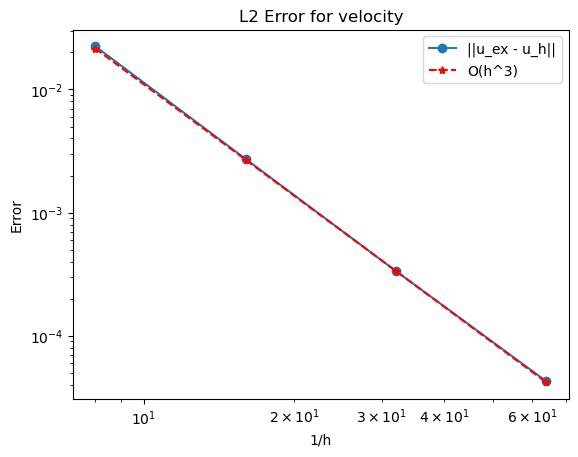

In [14]:
import matplotlib.pyplot as plt

plt.loglog(1/h[:total], error_L2_u, "o-", label= "||u_ex - u_h||")
plt.loglog(x_ref, asintota, "r*--", label=f"O(h^{order})")
plt.legend(loc="upper right")
plt.title(f"{norm_type} Error for velocity")
plt.xlabel("1/h")
plt.ylabel("Error")
plt.show()

In [15]:
Slope, intercept = np.polyfit(np.log(1/h[:total]), np.log(error_L2_u[:]), 1)
print(f"Tasa de convergencia en la norma {norm_type} = {-Slope}")

Tasa de convergencia en la norma L2 = 3.011199404242885


#### _H1 error_

In [16]:
norm_type = "H1"
error_H1_u = np.array([0. for i in range(total)])

for i in range(total): # N° meshes

    # N-indexed eigenvectors from the ith mesh
    u_h = u_h_list[i][N]
    V_h = u_h.function_space

    error_H1_u[i] = norm(norm_type,u_ex, V_ex, u_h, V_h, cells_fine_u)

In [17]:
order = 2
x_ref = 1/h[:total]
y0 = error_H1_u[-2]
x0 = x_ref[-2]
asintota = y0 * (x_ref/x0)**(-order)

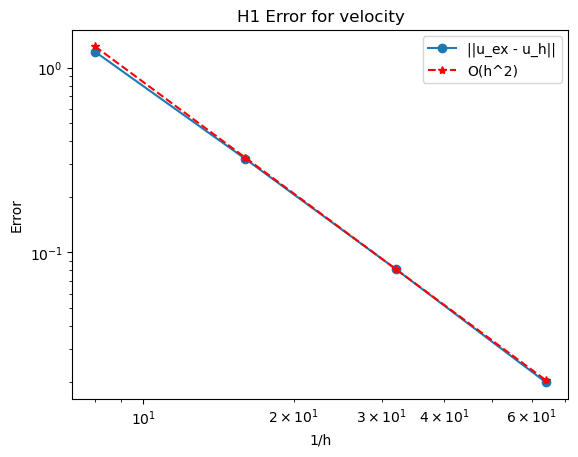

In [18]:
plt.loglog(1/h[:total], error_H1_u, "o-", label= "||u_ex - u_h||")
plt.loglog(x_ref, asintota, "r*--", label=f"O(h^{order})")
plt.legend(loc="upper right")
plt.title(f"{norm_type} Error for velocity")
plt.xlabel("1/h")
plt.ylabel("Error")
plt.show()

In [19]:
Slope, intercept = np.polyfit(np.log(1/h[:total]), np.log(error_H1_u[:]), 1)
print(f"Tasa de convergencia en la norma {norm_type} = {-Slope}")

Tasa de convergencia en la norma H1 = 1.9798496372779368


### _**Pressure**_

In [20]:
# Interpolamos cada solución sobre la malla fina
norm_type = "L2"
error_L2_p = np.array([0. for i in range(total)])

for i in range(total):

    # N-indexed eigenvectors from the ith mesh
    p_h = p_h_list[i][N]
    Q_h = p_h.function_space
    error_L2_p[i] = norm(norm_type,p_ex, Q_ex, p_h, Q_h, cells_fine_p)

In [21]:
order = 2
x_ref = 1/h[:total]
y0 = error_L2_p[-2]
x0 = x_ref[-2]
asintota = y0 * (x_ref/x0)**(-order) 

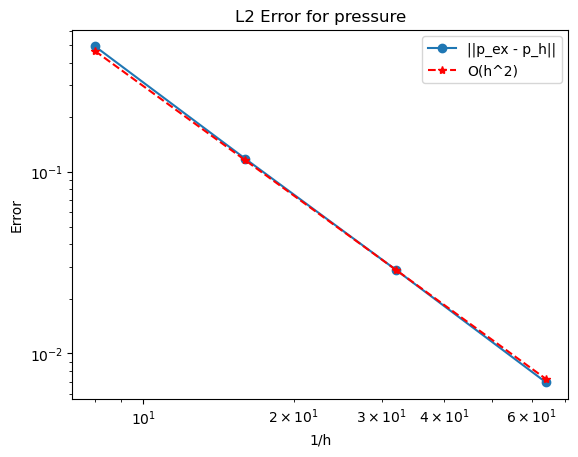

In [22]:
plt.loglog(1/h[:total], error_L2_p, "o-", label= "||p_ex - p_h||")
plt.loglog(x_ref, asintota, "r*--", label=f"O(h^{order})")
plt.legend(loc="upper right")
plt.title(f"{norm_type} Error for pressure")
plt.xlabel("1/h")
plt.ylabel("Error")
plt.show()

In [23]:
Slope, intercept = np.polyfit(np.log(1/h[:total]), np.log(error_L2_p[:]), 1)
print(f"Tasa de convergencia en la norma {norm_type} = {-Slope}")

Tasa de convergencia en la norma L2 = 2.0467120938909398


### _**Eigenvalues**_

In [24]:
error_eig = np.array([0. for i in range(total)])

for i in range(total):
    eig_h = eig_h_list[i][N]
    error_eig[i] = abs(eig_ex - eig_h)/abs(eig_ex)

In [25]:
order = 4
x_ref = 1/h[:total]
y0 = error_eig[-2]
x0 = x_ref[-2]
asintota = y0 * (x_ref/x0)**(-order) 

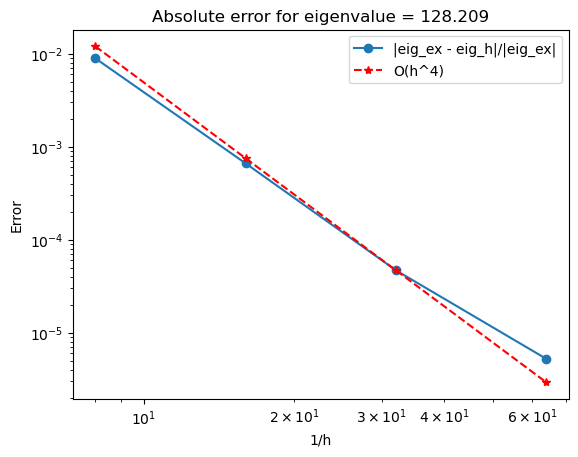

In [26]:
plt.loglog(1/h[:total], error_eig, "o-", label= "|eig_ex - eig_h|/|eig_ex|")
plt.loglog(x_ref, asintota, "r*--", label=f"O(h^{order})")
plt.legend(loc="upper right")
plt.title(f"Absolute error for eigenvalue = {round(eig_ex,3)}")
plt.xlabel("1/h")
plt.ylabel("Error")
plt.show()

In [27]:
Slope, intercept = np.polyfit(np.log(1/h[:total]), np.log(error_eig[:]), 1)
print(f"Tasa de convergencia en la norma {norm_type} = {-Slope}")

Tasa de convergencia en la norma L2 = 3.6014508150367193


In [28]:
print(eig_h_list)

[[129.3491186377653], [128.2937771836594], [128.21514276927235], [128.20981915993664], [128.20914874515006]]
